In [39]:
import logging

import numpy as np
import pandas as pd
import geopandas as gpd
import pyarrow.compute as pc
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import unary_union
from scipy.spatial import KDTree

from src.datalake import Datalake

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
plt.style.use('bmh')


def initialize_figure(w: int = 14, h: int = 10) -> any:
    return plt.subplots(figsize=(w, h))

In [42]:
data = Datalake("../data")
state_geoms = data.query_states()

scope_states = ["California", "Washington", "Oregon", "Montana", "Idaho", "Wyoming", "Utah", "Nevada", "Colorado", "Arizona", "New Mexico"]
scope_multipoly = unary_union(state_geoms[state_geoms.name.isin(scope_states)].geometry)

In [43]:
def load_datasets_by_scope_poly(
        scope_poly: MultiPolygon,
        perimeter_id_set: set[str] | None = None,
        station_id_set: set[str] | None = None,
) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    perimeters = data.query_fire_perimeter()
    stations = data.query_stations()

    if perimeter_id_set is not None:
        scoped_perimeters = perimeters[perimeters["OBJECTID"].isin(perimeter_id_set)]
    else:
        scoped_perimeters = perimeters[perimeters.geometry.intersects(scope_poly)]

    if station_id_set is not None:
        scoped_stations = stations[stations["station_id"].isin(station_id_set)]
    else:
        scoped_stations = stations[stations.geometry.within(scope_poly)]

    return scoped_perimeters, scoped_stations


perimeters, stations = load_datasets_by_scope_poly(
    scope_poly=scope_multipoly,
    # Use *_id_set=None to automatically do the computation
    # perimeter_id_set=pd.read_csv("california_perimeters_ids.csv")["OBJECTID"],
    # station_id_set=pd.read_csv("california_station_ids.csv")["station_id"]
)

perimeters.dropna(subset=["DISCOVERYDATETIME"], inplace=True)
perimeters['DISCOVERYDATETIME'] = pd.to_datetime(perimeters['DISCOVERYDATETIME'], utc=True, errors='coerce')
perimeters = perimeters.dropna(subset=['DISCOVERYDATETIME'])
all_perimeters = perimeters.copy()

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 0200/08/22 00:00:00+00, at position 1804. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [72]:
perimeters = all_perimeters[
    (all_perimeters["FIREYEAR"] > 2000) &
    (all_perimeters["TOTALACRES"] > 100)
]

In [73]:
perimeters.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2638 entries, 5 to 13499
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   OBJECTID           2638 non-null   int32              
 1   GLOBALID           2478 non-null   object             
 2   FIREOCCURID        1312 non-null   object             
 3   CN                 1874 non-null   object             
 4   REVDATE            2544 non-null   datetime64[ms, UTC]
 5   FIRENAME           2638 non-null   object             
 6   COMPLEXNAME        167 non-null    object             
 7   FIREYEAR           2638 non-null   float64            
 8   UNIQFIREID         2110 non-null   object             
 9   SOFIRENUM          1739 non-null   object             
 10  LOCALFIRENUM       1941 non-null   object             
 11  SECURITYID         2330 non-null   object             
 12  DISCOVERYDATETIME  2638 non-null   datetime6

In [74]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 20844 entries, 52998 to 41473
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   station_id  20844 non-null  object  
 1   latitude    20844 non-null  float64 
 2   longitude   20844 non-null  float64 
 3   elevation   20844 non-null  float64 
 4   state       20843 non-null  object  
 5   name        20844 non-null  object  
 6   geometry    20844 non-null  geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 1.3+ MB


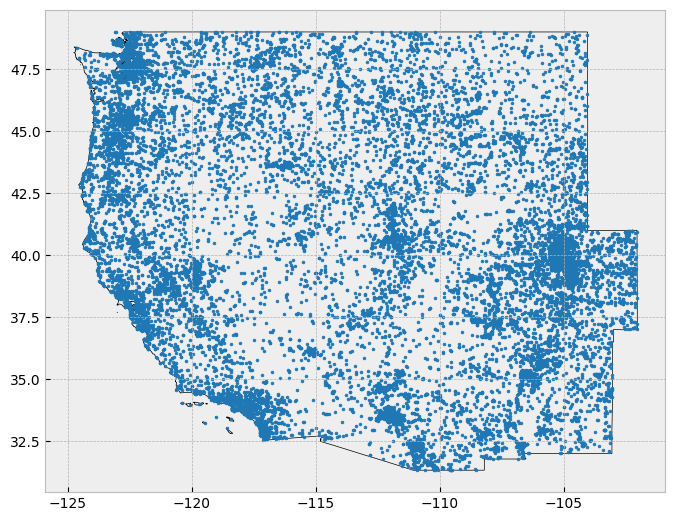

In [75]:
# Build spatial query tree for fast k-NN lookup, kd tree is good for low-dimensional and static data
station_xy = np.column_stack((stations.longitude, stations.latitude))
tree = KDTree(station_xy)

fig, ax = plt.subplots(figsize=(8, 8))

for geom in scope_multipoly.geoms:
    xs, ys = geom.exterior.xy
    ax.fill(xs, ys, alpha=1, ec="black", fc="None")

ax.scatter(stations.longitude, stations.latitude, s=4, c="tab:blue")
ax.set_aspect('equal', adjustable='box')

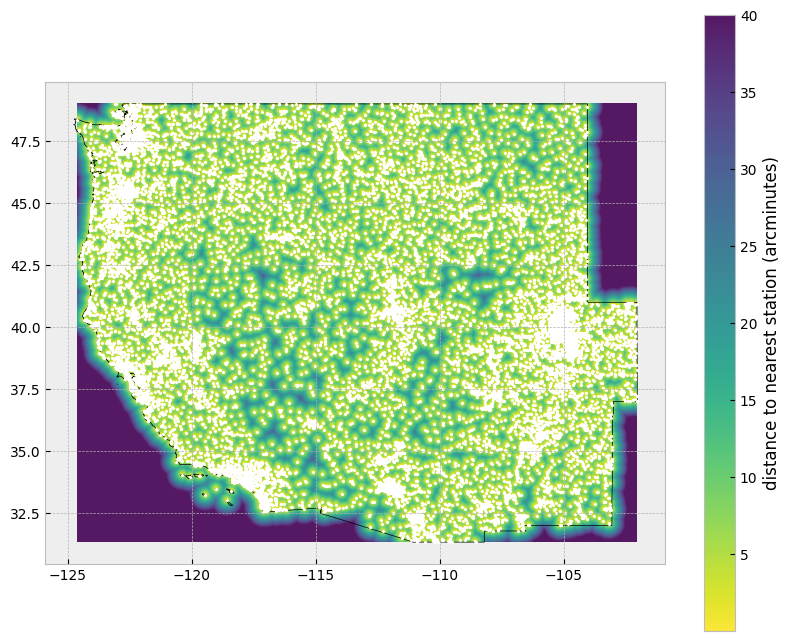

In [76]:
xmin, xmax = stations.longitude.min(), stations.longitude.max()
ymin, ymax = stations.latitude.min(), stations.latitude.max()

grid_res = 512
lon_grid = np.linspace(xmin, xmax, grid_res)
lat_grid = np.linspace(ymin, ymax, grid_res)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
grid_points = np.column_stack((lon_mesh.ravel(), lat_mesh.ravel()))

# Compute distances to the nearest station
dists, _ = tree.query(grid_points)
dists *= 60  # Convert to arcminutes
dist_grid = dists.reshape(grid_res, grid_res)

fig, ax = plt.subplots(figsize=(10, 8))
for geom in scope_multipoly.geoms:
    xs, ys = geom.exterior.xy
    ax.fill(xs, ys, alpha=1, ec="black", fc="None")
c = ax.imshow(dist_grid, extent=[xmin, xmax, ymin, ymax], origin="lower", cmap="viridis_r", alpha=0.9, vmax=40)
ax.scatter(stations.longitude, stations.latitude, s=1, c="white", marker="x")
fig.colorbar(c, ax=ax, label="distance to nearest station (arcminutes)")
ax.set_aspect('equal', adjustable='box')

In [77]:
# Expand the geometry of a fire perimeter to get a geometry that is within some distance from the fire
# This can be done by doing a minkowski sum of the perimeter with a circle radius n
minkowski_sum_radius_deg = 0.25  # 0.25 degrees = around 25km
perimeters["expanded_geometry"] = perimeters.geometry.buffer(
    distance=minkowski_sum_radius_deg, resolution=2
)
# This takes a while (~1 min), larger expansions take less time up to a certain point
# Ignore warning, we don't really care how the curvature of the planet in California differs from the
# overall ellipsoidal curvature of the Earth

# We can then find all weather stations inside the fire's expanded perimeter

C:\Users\katac\AppData\Local\Temp\ipykernel_16120\1616303943.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  perimeters["expanded_geometry"] = perimeters.geometry.buffer(
C:\Users\katac\things\_s\ds401\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [78]:
# Naive implementation is O(nm), takes around 2s per station id, for 3.2k stations ids, so around 2 hours
#
### perimeter_stations = {row.OBJECTID: [] for _, row in perimeters.iterrows()}
###
### for i, station_row in stations.iterrows():
###     station_id, pt = station_row.station_id, station_row.geometry
###     if not isinstance(pt, Point):
###         continue
###
###     for j, perimeter_row in perimeters.iterrows():
###         sid, poly = perimeter_row.OBJECTID, perimeter_row.geometry
###         if isinstance(poly, (Polygon, MultiPolygon)) and poly.contains(pt):
###             perimeter_stations[sid].append(station_id)wit


# I use an optimized approach with a spatial tree instead, O((m + n) log n), n is number of fire perimeters
# Speed up factor of 1000, finishes in around 2-3 seconds
### import rtree
### rt = rtree.index.Index()
###
### poly_dict = {}
###
### print("Constructing R-tree from polygon bounding boxes")
### for idx, (_, row) in enumerate(perimeters.iterrows()):
###     if idx % 5000 == 0: print(f"{idx} / {len(perimeters)} multi-polys inserted")
###
###     sid, poly = row.OBJECTID, row.geometry
###     if isinstance(poly, (Polygon, MultiPolygon)):
###         rt.insert(sid, poly.bounds)
###         poly_dict[sid] = poly
###
perimeter_stations = {sid: [] for sid in perimeters["OBJECTID"]}
### print("Associating weather stations to fire perimeters")
### for idx, (_, row) in enumerate(stations.iterrows()):
###     if idx % 1000 == 0: print(f"{idx} / {len(stations)} stations processed")
###
###     station_id, pt = row.station_id, row.geometry
###     # Find candidate perimeters using R-tree bounding box lookup
###     candidate_polys = [sid for sid in rt.intersection((pt.x, pt.y, pt.x, pt.y))]
###
###     # Validate using actual point-in-polygon test
###     for sid in candidate_polys:
###         if poly_dict[sid].contains(pt):
###             perimeter_stations[sid].append(station_id)

# Never mind, just do this, runs in like milliseconds
perimeter_stations |= (
    gpd
    .sjoin(
        left_df=stations.copy(),
        right_df=perimeters.copy().set_geometry("expanded_geometry"),
        how="left",
        predicate="within"
    )
    .groupby("OBJECTID")["station_id"]
    .apply(list).to_dict()
)

In [79]:
perimeter_stations

{21869404: ['US1IDID0004',
  'US1IDID0005',
  'US1IDID0011',
  'US1IDID0012',
  'USC00104793',
  'USC00105011',
  'USC00105013',
  'USC00105015'],
 21869413: ['USC00106085',
  'USC00106087',
  'USC00107320',
  'USR0000IPOW',
  'USS0014C04S'],
 21869414: ['USC00240565', 'USR0000MSPO'],
 21869415: ['USC00248101',
  'USR0000MBDP',
  'USR0000MGAT',
  'USS0012A02S',
  'USS0012B12S',
  'USS0012B13S',
  'USS0013A15S'],
 21869417: ['USR0000MGAT'],
 21869420: ['US1MTLK0003',
  'US1MTLK0010',
  'US1MTLK0013',
  'US1MTLK0014',
  'US1MTLK0017',
  'USC00240755',
  'USR0000MCON',
  'USS0013B24S',
  'USS0013B25S'],
 21869423: ['US1MTMS0016',
  'US1MTMS0017',
  'US1MTMS0018',
  'US1MTMS0026',
  'US1MTPW0003',
  'USC00240758',
  'USC00245043',
  'USC00246302',
  'USC00246304',
  'USC00246307',
  'USC00247448',
  'USR0000MBEN',
  'USR0000MSEE',
  'USS0012B14S',
  'USS0013C38S'],
 21869424: ['USC00101422',
  'USC00107561',
  'USC00109963',
  'USR0000ILOD',
  'USR0000IRED',
  'USS0015D06S'],
 21869425: ['

In [80]:
stations

,station_id,latitude,longitude,elevation,state,name,geometry
52998,US10RMHS145,40.5268,-105.1113,1569.1,CO,RMHS 1.6 SSW,POINT (-105.1113 40.5268)
53997,US10perk001,40.9528,-102.0538,1106.1,NE,BIG SPRINGS 7.6 S,POINT (-102.0538 40.9528)
55765,US1AZAP0002,32.3471,-110.9996,748.9,AZ,TUCSON 9.9 NNW,POINT (-110.9996 32.3471)
55766,US1AZAP0003,36.3047,-109.2233,2141.8,AZ,TSAILE 0.5 WNW,POINT (-109.2233 36.3047)
55767,US1AZAP0004,36.2949,-109.2220,2147.0,AZ,TSAILE 0.7 S,POINT (-109.222 36.2949)
...,...,...,...,...,...,...,...
24595,CA001103635,49.0000,-122.2167,8.0,BC,HUNTINGDON METER STATION,POINT (-122.2167 49)
24963,CA001135126,49.0000,-118.7667,580.0,BC,MIDWAY,POINT (-118.7667 49)
24994,CA001144230,49.0000,-116.1833,820.0,BC,KINGSGATE,POINT (-116.1833 49)
25014,CA001146000,49.0000,-117.8167,673.0,BC,PATERSON,POINT (-117.8167 49)


In [81]:
lookback_days = 30
results = []

for i, (_, fire_perimeter) in enumerate(perimeters.iterrows()):
    if i % 50 == 0: print(f"{i} / {len(perimeters)}")

    discovery_time = fire_perimeter["DISCOVERYDATETIME"]
    start_time = discovery_time - pd.Timedelta(days=lookback_days)

    stations = perimeter_stations[fire_perimeter["OBJECTID"]]
    if not stations: continue

    # Build a range of dates for the past lookback_days
    date_iter = (
        (pc.field("year") == d.year) & (pc.field("month") == d.month) & (pc.field("day") == d.day)
        for d in pd.date_range(start=start_time, end=discovery_time)
    )

    # Accumulate into one query
    date_query = next(date_iter)
    for q in date_iter:
        date_query |= q

    # Combine with weather station id query
    full_query = date_query & pc.field("station_id").isin(stations)

    # Replace NA with 0
    df = data.query_ghcnd(full_query)
    if df.empty:
        print(_, discovery_time, stations)
        continue


    # Aggregate with median
    agg = df[["prcp", "snow", "snwd", "tmax", "tmin"]].mean(numeric_only=True)
    agg["OBJECTID"] = fire_perimeter["OBJECTID"]
    results.append(agg)

0 / 2638
15 2015-08-12 00:00:00+00:00 ['USC00240565', 'USR0000MSPO']
18 2015-08-14 00:00:00+00:00 ['USR0000MGAT']
121 2018-08-24 22:35:00+00:00 ['USC00240758', 'USR0000MGAT']
125 2018-08-22 22:46:00+00:00 ['USC00240758', 'USR0000MGAT']
144 2018-08-12 04:40:00+00:00 ['US1MTFH0024', 'USC00240565', 'USC00242812']
50 / 2638
182 2015-08-03 00:00:00+00:00 ['USR0000MGAT']
183 2017-08-30 17:10:00+00:00 ['USR0000MSPO']
300 2011-07-19 00:00:00+00:00 ['USC00240758']
305 2003-08-05 00:00:00+00:00 ['USC00240758']
315 2009-07-26 00:00:00+00:00 ['USC00240758']
370 2011-08-16 00:00:00+00:00 ['US1MTMS0027', 'USC00240758']
393 2017-07-16 18:37:00+00:00 ['USC00240758']
100 / 2638
414 2022-07-21 20:45:00+00:00 ['US1MTRB0007', 'USC00240819', 'USC00240821']
468 2017-08-16 16:20:00+00:00 ['USC00106085', 'USC00106087']
533 2003-07-16 00:00:00+00:00 ['USC00240758']
539 2003-08-08 00:00:00+00:00 ['USC00240758']
558 2007-06-29 00:00:00+00:00 ['USC00240758']
569 2003-08-05 00:00:00+00:00 ['USC00240758']
630 2003-

KeyboardInterrupt: 

In [82]:

# fpw: fire perimeter weather
fpw = pd.DataFrame(results).set_index("OBJECTID")

# Convert to degrees C
fpw["tmax"] = fpw["tmax"] / 10
fpw["tmin"] = fpw["tmin"] / 10


In [83]:
fpw.fillna(value=0)

,prcp,snow,snwd,tmax,tmin
OBJECTID,,,,,
21869404.0,11.177419,0.0,0.000000,33.625000,10.645833
21869413.0,4.096774,0.0,0.000000,28.361290,9.030645
21869415.0,1.225806,0.0,0.000000,22.741935,8.132258
21869420.0,24.612069,0.0,2.542857,18.937624,6.240594
21869423.0,1.712871,0.0,0.000000,28.029032,8.572043
...,...,...,...,...,...
21871210.0,3.120968,0.0,0.000000,23.925806,9.101613
21871224.0,0.550000,0.0,0.000000,0.000000,0.000000
21871225.0,4.884615,0.0,11.473118,27.982258,10.316129


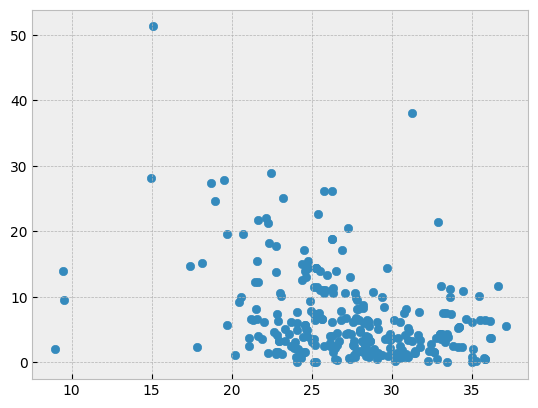

In [87]:
plt.scatter(x=fpw.tmax, y=fpw.prcp)